In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Input, Model, Sequential
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense, LSTM
from keras.utils.vis_utils import plot_model

# additionally openpyxl dependency is required -> pip install openpyxl

In [3]:
model_output_path = os.path.join('output', 'lstm.pdf')

# function from the p300-nengo-snn-params.ipynb that returns the model
def create_model():
    """
    Function to create tensorflow model
    """
    inp = Input(shape=(3, 1200, 1), name='input_layer')
    conv2d = Conv2D(filters=6, kernel_size=(3, 3), activation=tf.nn.relu)(inp)
    dropout1 = Dropout(0.5)(conv2d)
    avg_pooling = AveragePooling2D(pool_size=(1, 8), padding='same')(dropout1)
    flatten = Flatten()(avg_pooling)
    dense1 = Dense(100, activation=tf.nn.relu)(flatten)
    batch_norm = BatchNormalization()(dense1)
    dropout2 = Dropout(0.5)(batch_norm)
    output = Dense(2, activation=tf.nn.softmax, name='output_layer')(dropout2)

    return Model(inputs=inp, outputs=output)

def lstm_model():
    model = Sequential([
        LSTM(124, input_shape=(14, 360), activation='relu', return_sequences=True),
        Dropout(0.4),
        BatchNormalization(),
        LSTM(124, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax', name='output_layer')
    ])

    return model

plot_model(lstm_model(), to_file=model_output_path, show_shapes=True, show_layer_names=False)

In [ ]:
snn_config_path = os.path.join('output', 'snn_config.json') # path to json with configurations of SNN
acc_path = os.path.join('output', 'values.xlsx') # path to accuracy values for each iteration

acc_top_10_save_path_svg = os.path.join('output', 'acc_top_10.svg')
acc_top_10_save_path_pdf = os.path.join('output', 'acc_top_10.pdf')

with open(snn_config_path, 'r') as file:
    json_data = file.read()

snn_config = json.loads(json_data)

# print configurations
print('Configurations:')
for variant in snn_config:
    if variant['synapse'] == 'None':
        print('Time steps: {}, Scale Firing Rates: {}, Synapse: None'
              .format(variant['timesteps'], variant['scale_firing_rates']))
    else:
        print('Time steps: {}, Scale Firing Rates: {}, Synapse: {:4f}'
              .format(variant['timesteps'], variant['scale_firing_rates'], variant['synapse']))

In [59]:
# get dataframes from excel spreadsheet (this was created in the p300-nengo-snn-params notebook)
accs_df = pd.read_excel(acc_path, index_col=0, nrows=30)
print(accs_df)

    iterations  ann_accuracy  \
1            1        0.6360   
2            2        0.6375   
3            3        0.6370   
4            4        0.6340   
5            5        0.6380   
6            6        0.6405   
7            7        0.6365   
8            8        0.6400   
9            9        0.6390   
10          10        0.6460   
11          11        0.6405   
12          12        0.6335   
13          13        0.6485   
14          14        0.6475   
15          15        0.6430   
16          16        0.6205   
17          17        0.6475   
18          18        0.6375   
19          19        0.6400   
20          20        0.6375   
21          21        0.6260   
22          22        0.6450   
23          23        0.6375   
24          24        0.6355   
25          25        0.6440   
26          26        0.6355   
27          27        0.6075   
28          28        0.6425   
29          29        0.6255   
30          30        0.6330   

    snn

    iterations  ann_accuracy  \
13          13        0.6485   
17          17        0.6475   
14          14        0.6475   
10          10        0.6460   
22          22        0.6450   
25          25        0.6440   
15          15        0.6430   
28          28        0.6425   
6            6        0.6405   
11          11        0.6405   

    snn [timesteps=50, scaling=1000, synapse=0.010000]  \
13                                           0.647586    
17                                           0.641115    
14                                           0.648581    
10                                           0.646093    
22                                           0.644599    
25                                           0.644102    
15                                           0.644599    
28                                           0.640119    
6                                            0.642608    
11                                           0.641115    

    snn 

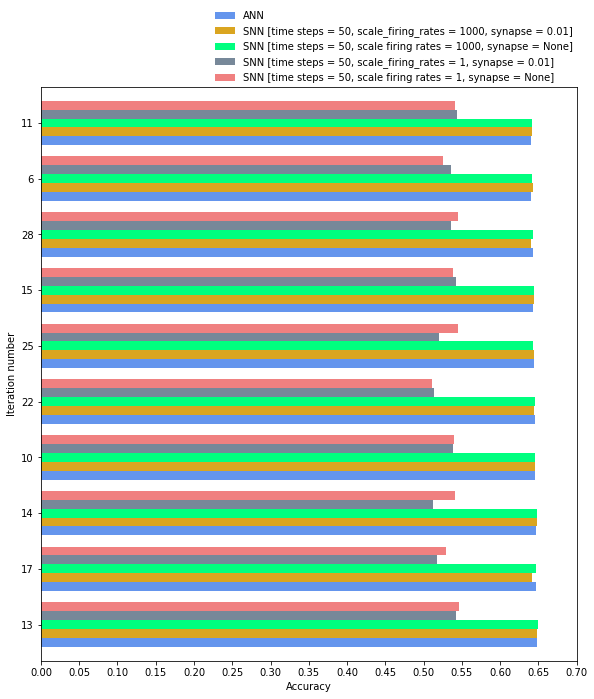

In [60]:
# create chart for accuracies per configuration of snn compared to ann
top_10_accs_df = accs_df.sort_values('ann_accuracy', ascending=False)[:10]
print(top_10_accs_df)
colors = ['CornflowerBlue', 'GoldenRod', 'SpringGreen', 'LightSlateGray', 'LightCoral']
ax = top_10_accs_df.plot.barh(x='iterations', y=top_10_accs_df.columns[1:],
                        width=0.8, color=colors,  figsize=[6.4 * 1.5, 8.8 * 1.2])


plt.xticks(np.arange(0, .75, 0.05))
plt.yticks(rotation=0)
plt.xlabel('Accuracy')
plt.ylabel('Iteration number')

# rename legend labels
legend_labels = ['ANN']
for variant in snn_config:
    if variant['synapse'] == 'None':
        name = 'SNN [time steps = {}, scale firing rates = {}, synapse = None]'.format(
            variant['timesteps'], variant['scale_firing_rates']
        )
    else:
        name = 'SNN [time steps = {}, scale_firing_rates = {}, synapse = {:.2f}]'.format(
            variant['timesteps'], variant['scale_firing_rates'], variant['synapse']
        )

    legend_labels.append(name)

ax.legend(labels=legend_labels, loc='lower right', frameon=False, bbox_to_anchor=(1.0, 1.0),
          ncol=1, borderaxespad=0.)

# save output as svg and pdf file
plt.savefig(acc_top_10_save_path_svg, bbox_inches='tight')
plt.savefig(acc_top_10_save_path_pdf, bbox_inches='tight')
plt.show()
